# Zillow Project  Workbook

-------------------------------------------------



## Import Menagerie

In [1]:
# Foundation
import pandas as pd
import numpy as np
from scipy import math

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns


# Metric and Modeling Tools
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression

# Custom
import wrangle_prep as wp
import explore as ep


# Required Data
df = wp.wrangle_zillow()
df.head(3)

Reading cleaned data from csv file...


,bedrooms,bathrooms,sqr_feet,tax_value,year_built,fips
0,4.0,2.0,3633.0,296425.0,2005,6037
1,3.0,2.0,2077.0,646760.0,1926,6037
2,0.0,0.0,1200.0,5328.0,1972,6037


In [2]:
# Check for nulls
df.isnull().sum()

bedrooms      0
bathrooms     0
sqr_feet      0
tax_value     0
year_built    0
fips          0
dtype: int64

In [3]:
# Look into our target variable

df.tax_value.describe()
# There are some fairly big outliers in the top 25%

count    1.928451e+06
mean     3.282706e+05
std      1.972988e+05
min      1.000000e+00
25%      1.738245e+05
50%      2.980000e+05
75%      4.562450e+05
max      8.477320e+05
Name: tax_value, dtype: float64

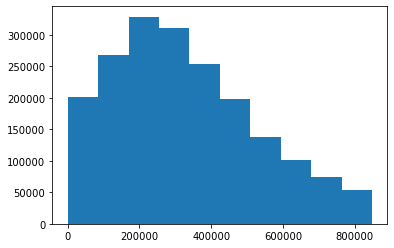

In [4]:
plt.hist(x='tax_value', data=df)
plt.show()

In [5]:
# Split our data for manipulation
train, validate, test = wp.split_data(df)

train <> (1079932, 6)
validate <> (462828, 6)
test <> (385691, 6)


In [6]:
# Variables for constructing models

x_train = train.drop(columns=['tax_value'])
y_train = train.tax_value

x_validate = validate.drop(columns=['tax_value'])
y_validate = validate.tax_value

x_test = test.drop(columns=['tax_value'])
y_test = test.tax_value


In [7]:
# Scaled Versions of the data

# Make it
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit it
scaler.fit(x_train)

# Use it
x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)


In [8]:
# Got my data and it's prepped, now lets explore a bit
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928451 entries, 0 to 1928450
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   sqr_feet    float64
 3   tax_value   float64
 4   year_built  int64  
 5   fips        int64  
dtypes: float64(4), int64(2)
memory usage: 88.3 MB


In [9]:
# Recursive Feature Selection
ep.rfe_feature_rankings(x_train_scaled, x_train, y_train, 1)

,Var,Rank
2,sqr_feet,1
1,bathrooms,2
0,bedrooms,3
3,year_built,4
4,fips,5


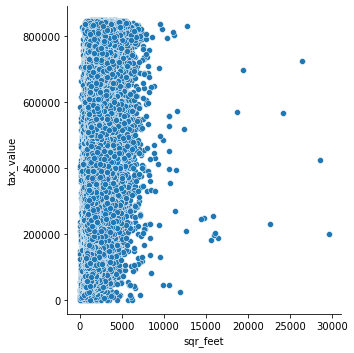

In [10]:
# Judging from the RFE ranking, gonna look into square footage more
sns.relplot(x='sqr_feet', y='tax_value', data=train)
plt.show()

In [11]:
# Well that's and outlier that throws the graph
train.sqr_feet.describe()

count    1.079932e+06
mean     1.690592e+03
std      6.593296e+02
min      1.000000e+00
25%      1.227000e+03
50%      1.555000e+03
75%      2.025000e+03
max      2.962000e+04
Name: sqr_feet, dtype: float64

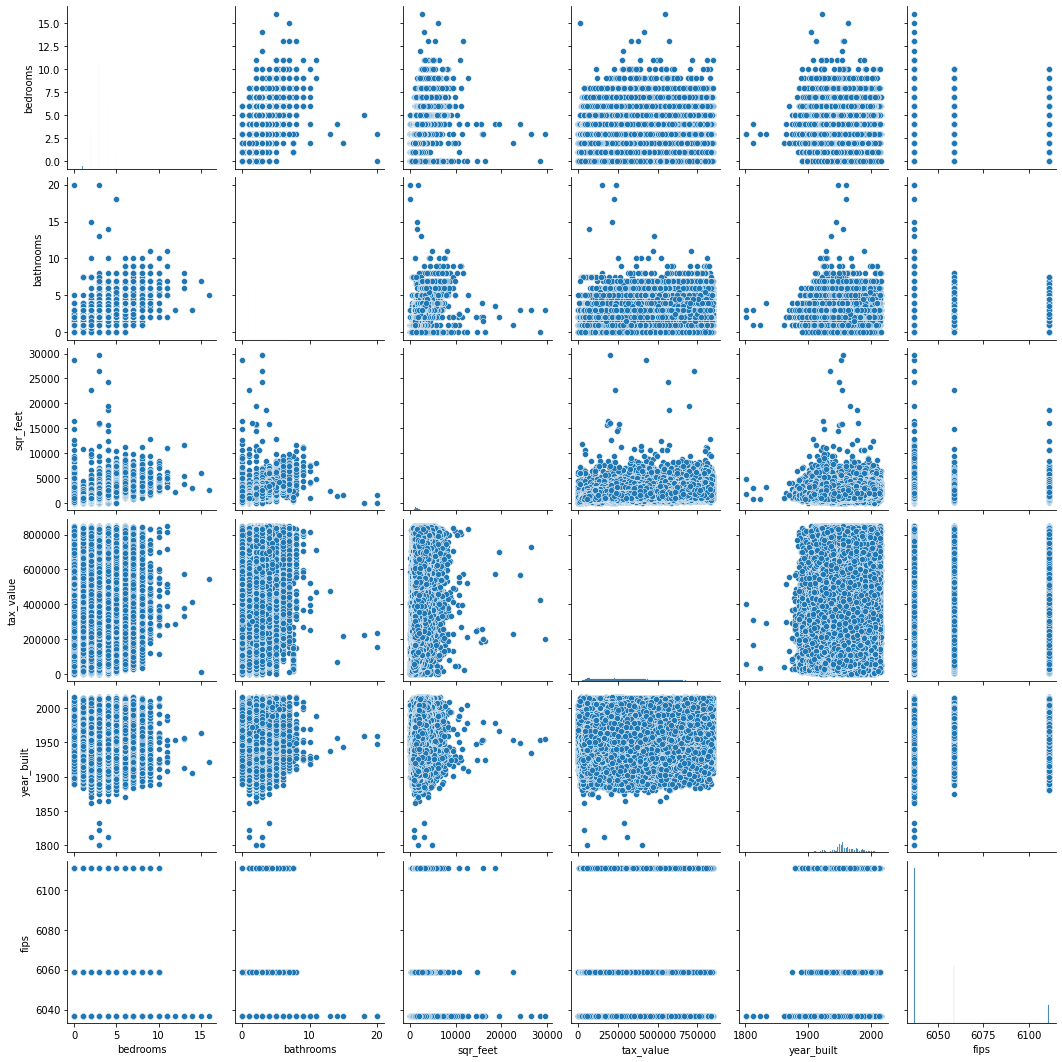

In [13]:
# look for any obvious relationships
sns.pairplot(train)
plt.show()